# Simple LSTM models for discretized ACTS data

In this notebook we will test out some of our LSTM models for discrete 3D data on my ACTS data.

We will use a binning per-barrel-volume to exploit the differences in sizes and densities.

In [1]:
# Select a GPU first
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
from __future__ import print_function

# System imports
import ast

# Data handling
import numpy as np
import pandas as pd

# Machine learning
from keras import layers, models

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

# Local imports
from data import load_data_events
from metrics import calc_hit_accuracy

%matplotlib notebook

Using TensorFlow backend.


## Data utilities

#### Data processing

In [3]:
def process_hits_data(df, copy_keys=['evtid', 'barcode', 'volid', 'layid']):
    """Split columns and calculate some derived variables"""
    x = df.gpos.apply(lambda pos: pos[0])
    y = df.gpos.apply(lambda pos: pos[1])
    z = df.gpos.apply(lambda pos: pos[2])
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return df[copy_keys].assign(z=z.astype(np.float32), r=r.astype(np.float32),
                                phi=phi.astype(np.float32))

def process_files(hits_files):
    """Load and process a set of hits files"""
    # Column names
    hits_columns = ['hitid', 'barcode', 'volid', 'layid', 'lpos',
                    'lerr', 'gpos', 'chans', 'dir', 'direrr']
    # Loop over corresponding files
    hits = []
    evtid = 0
    for hits_file in hits_files:
        # Load this hits file
        hits.append(process_hits_data(
            load_data_events(os.path.join(data_dir, hits_file),
                             columns=hits_columns, start_evtid=evtid)))
        evtid = hits[-1].evtid.iloc[-1]
    # Concatenate and return the results
    return pd.concat(hits, ignore_index=True)

#### Data selection

In [4]:
def select_hits(hits):
    # Select all barrel hits
    vids = [8, 13, 17]
    barrel_hits = hits[np.logical_or.reduce([hits.volid == v for v in vids])]
    # Re-enumerate the volume and layer numbers for convenience
    volume = pd.Series(-1, index=barrel_hits.index, dtype=np.int8)
    vid_groups = barrel_hits.groupby('volid')
    for i, v in enumerate(vids):
        volume[vid_groups.get_group(v).index] = i
    # This assumes 4 layers per volume (except last volume)
    layer = (barrel_hits.layid / 2 - 1 + volume * 4).astype(np.int8)
    return (barrel_hits[['evtid', 'barcode', 'phi', 'z']]
            .assign(volume=volume, layer=layer))

def select_signal_hits(hits):
    """Select signal hits from tracks that hit all three volumes"""
    return (hits.groupby(['evtid', 'barcode'])
            .filter(lambda x: x.volume.unique().size == 3))

#### Metrics

In [5]:
def binmask_prediction(inputs, preds, threshold=0.1):
    """
    Finalize a model prediction by masking with the data, selecting the
    top scoring categories, and applying a threshold decision.
    """
    # Mask the predictions with the data (converted to bool)
    preds = preds * (inputs > 0.5)
    # Find the values of the max predictions
    max_preds = preds.max(axis=2)
    # Keep only the max masked prediction per layer
    preds[preds < max_preds[:,:,np.newaxis]] = 0
    # Apply the threshold for the final boolean prediction
    return preds > threshold

def volbinmask_accuracy(inputs, targets, preds, threshold=0.1):
    """Fraction of masked, binarized layers in given volumes that match target."""
    vols = range(len(test_input))
    # Mask and binarize the prediction
    preds = [binmask_prediction(inputs[v], preds[v]) for v in vols]
    # Convert target to boolean
    targets = [(t > 0.5) for t in targets]
    # Find matches
    matches = [np.all(preds[v] == targets[v], axis=2) for v in vols]
    # Calculate accuracy
    return float(sum(map(np.sum, matches))) / sum(map(np.size, matches))

#### Drawing

In [6]:
def draw_train_history(history, loss_keys=['loss'], acc_keys=['acc'], figsize=(12,5)):
    """Make plots of training and validation losses and accuracies"""
    fig = plt.figure(figsize=figsize)
    # Plot loss
    plt.subplot(121)
    for key in loss_keys:
        plt.plot(history.epoch, history.history[key], label=key)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.legend()
    plt.subplot(122)
    for key in acc_keys:
        plt.plot(history.epoch, history.history[key], label=key)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim((0, 1))
    plt.title('Training accuracy')
    plt.legend(loc=0)
    plt.tight_layout()

def draw_vol_projections(event, bins, ranges,
                         axis_labels=['Layer', '$\phi$', 'Z [mm]'],
                         figsize=(12, 3), cmap='gray_r'):
    """Draws the 2D projections of 3D volumes"""
    nvols = len(event)
    # Get the projections - reshape for convenience
    zprojs = [event[i].reshape(bins[i]).sum(axis=1) for i in range(nvols)]
    pprojs = [event[i].reshape(bins[i]).sum(axis=2) for i in range(nvols)]
    
    plt.figure(figsize=figsize)
    imshow_args = dict(interpolation='none', aspect='auto', origin='lower', cmap=cmap)
    
    # Draw Z vs. layer
    plt.subplot(121)
    vcols = ['r', 'b', 'g']
    for i in range(nvols):
        lay_range, phi_range, z_range = ranges[i]
        # Draw the detector image
        plt.imshow(zprojs[i], extent=z_range+lay_range, **imshow_args)
        # Draw some lines around the volume
        vpos = (z_range[0], lay_range[0])
        vwidth, vheight = z_range[1]-z_range[0], lay_range[1]-lay_range[0]
        plt.gca().add_patch(patches.Rectangle(vpos, vwidth, vheight,
                                              fill=False, ls=':', color=vcols[i%3]))
    plt.ylim((ranges[0][0][0], ranges[-1][0][-1]))
    plt.xlabel(axis_labels[2])
    plt.ylabel(axis_labels[0])

    # Draw phi vs. layer
    plt.subplot(122)
    for i in range(nvols):
        lay_range, phi_range, z_range = ranges[i]
        # Draw the detector image
        plt.imshow(pprojs[i], extent=phi_range+lay_range, **imshow_args)
        # Draw some lines around the volume
        vpos = (phi_range[0], lay_range[0])
        vwidth, vheight = phi_range[1]-phi_range[0], lay_range[1]-lay_range[0]
        plt.gca().add_patch(patches.Rectangle(vpos, vwidth, vheight,
                                              fill=False, ls=':', color=vcols[i%3]))
    plt.ylim((ranges[0][0][0], ranges[-1][0][-1]))
    plt.xlabel(axis_labels[1])
    plt.ylabel(axis_labels[0])
    
    plt.tight_layout()

## Read the data

In [7]:
data_dir = '/bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29'

In [8]:
all_files = os.listdir(data_dir)
hits_files = sorted(f for f in all_files if f.startswith('clusters'))
#particles_files = sorted(f for f in all_files if f.startswith('particles'))

num_train_files = 80
train_hits_files = hits_files[:num_train_files]
#train_particles_files = particles_files[:num_train_files]

In [ ]:
hits = process_files(train_hits_files)
#hits, particles = process_files(train_hits_files, train_particles_files)

Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_1.csv
Finished event 0
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_10.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_100.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_11.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_12.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_13.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_14.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_15.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_16.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_17.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_18.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_19.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_2.csv
Loading /bigdata/shared/ACTS/prod_m

In [12]:
print('Hits data shape:', hits.shape)
#print('Particles data shape:', particles.shape)

Hits data shape: (42159135, 7)


## LSTM hit classification model

Here we define the model and the batch generator code. Then we train the model on our data.

In [13]:
def build_model(input_shapes, hidden_dim,
                loss = 'categorical_crossentropy',
                optimizer = 'Nadam', metrics = ['accuracy']):
    """Build LSTM model for ordered, binned input volumes"""
    vols = range(len(input_shapes))
    # I need one input layer per volume
    inputs = [layers.Input(shape=s) for s in input_shapes]
    # Use FC transformations to map each detector layer onto a fixed size
    hidden = [layers.TimeDistributed(layers.Dense(hidden_dim, activation='relu'))(inp)
              for inp in inputs]
    # Concatenate the tensors together to make one sequence
    hidden_merged = layers.merge(hidden, mode='concat', concat_axis=1)
    # Apply the LSTM to the detector layer sequence
    hidden_lstm = layers.LSTM(output_dim=hidden_dim, return_sequences=True)(hidden_merged)
    # Use Lambda layers to split the sequence by volume
    vol_edges = np.cumsum([0] + [s[0] for s in input_shapes])
    hidden_split = [layers.Lambda(lambda x: x[:,vol_edges[v]:vol_edges[v+1],:])(hidden_lstm)
                    for v in vols]
    # Use FC transformations to map back onto volume sizes
    output_names = [('vol_%i_output' % v) for v in vols]
    outputs = [layers.TimeDistributed(layers.Dense(input_shapes[v][1], activation='softmax'),
                                      name=output_names[v])(hidden_split[v])
               for v in vols]
    # Compile the model
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [14]:
def make_hist_func(bins, ranges, dtype=np.float32):
    """Returns a function which can bin some hits into specified binning"""
    return lambda hits: np.histogramdd(
        (hits.layer.values, hits.phi.values, hits.z.values),
        bins=bins, range=ranges)[0].astype(dtype)

def batch_generator(hits, signal_hits, signal_keys, batch_size,
                    bins, ranges, seed_size=3, dtype=np.float32):
    """
    Batch generator for volume-binning of barrel detector hits.
    To speed things up, we pre-bin all of the events. To conserve
    memory we bin the signal hits on-the-fly. This is slow, though.
    """
    
    # Histogramming functions for each volume
    hist_funcs = [make_hist_func(vbins, vranges) for (vbins, vranges) in zip(bins, ranges)]

    # Split hits by volume, group by key
    hit_groups = [g.groupby('evtid') for (v, g) in hits.groupby('volume')]
    sig_hit_groups = [g.groupby(['evtid', 'barcode']) for (v, g) in signal_hits.groupby('volume')]
    
    # Pre-bin all the events
    evt_hists = [hg.apply(hf) for (hg, hf) in zip(hit_groups, hist_funcs)]
    
    # Chop excess sample keys to have only full batches
    num_batches = signal_keys.shape[0] // batch_size
    keys = signal_keys[:num_batches*batch_size].reshape((num_batches, batch_size, -1))
    
    while True:
        
        # Loop over batches
        for batch_keys in keys:
            
            # Get the evt hists in this batch
            batch_evt_hists = [np.stack(h[batch_keys[:,0]]) for h in evt_hists]

            # Construct the sig hists in this batch
            key_tuples = map(tuple, batch_keys)
            batch_sig_hits = [map(hg.get_group, key_tuples) for hg in sig_hit_groups]
            batch_sig_hists = [np.stack(map(hf, bsh)) for (hf, bsh) in zip(hist_funcs, batch_sig_hits)]
            
            # Finalize model input and target
            model_input = [h.reshape(h.shape[0], h.shape[1], -1) for h in batch_evt_hists]
            model_target = [h.reshape(h.shape[0], h.shape[1], -1) for h in batch_sig_hists]
            # Remove background hits from seed layers
            model_input[0][:,:seed_size] = model_target[0][:,:seed_size]
            # Clip target to 1
            for i in range(len(bins)):
                model_target[i][model_target[i] > 1] = 1
            
            yield model_input, model_target

In [15]:
%%time
# Select hits
selected_hits = select_hits(hits)
signal_hits = select_signal_hits(selected_hits)

# Find and shuffle the samples
keys = signal_hits[['evtid', 'barcode']].drop_duplicates().values
np.random.shuffle(keys)
print('Number of samples available:', keys.shape[0])

Number of samples available: 1294283
CPU times: user 14min 7s, sys: 3.49 s, total: 14min 11s
Wall time: 14min 9s


In [16]:
# Data config
vols = [0, 1, 2]
v0_bins = [4, 64, 64]
v0_ranges = [[0, 4], [-np.pi, np.pi], [-500, 500]]
v1_bins = [4, 64, 64]
v1_ranges = [[4, 8], [-np.pi, np.pi], [-1080, 1080]]
v2_bins = [2, 64, 21]
v2_ranges = [[8, 10], [-np.pi, np.pi], [-1031, 1031]]
bins = [v0_bins, v1_bins, v2_bins]
ranges = [v0_ranges, v1_ranges, v2_ranges]

# Number of seed layers
seed_size = 3

In [17]:
# Model config
hidden_dim = 256
loss = 'categorical_crossentropy'
optimizer = 'Nadam'
metrics = ['accuracy']
input_shapes = [
    [v0_bins[0], v0_bins[1]*v0_bins[2]],
    [v1_bins[0], v1_bins[1]*v1_bins[2]],
    [v2_bins[0], v2_bins[1]*v2_bins[2]]
]

# Training config
batch_size = 64
num_epoch = 10
samples_per_epoch = (keys.shape[0] // batch_size) * batch_size

In [18]:
# Build the model
model = build_model(input_shapes, hidden_dim)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 4, 4096)       0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 4, 4096)       0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 2, 1344)       0                                            
____________________________________________________________________________________________________
timedistributed_1 (TimeDistribut (None, 4, 256)        1048832     input_1[0][0]                    
___________________________________________________________________________________________

In [ ]:
train_batcher = batch_generator(selected_hits, signal_hits, keys, batch_size, bins, ranges)
history = model.fit_generator(train_batcher, nb_epoch=num_epoch,
                              samples_per_epoch=samples_per_epoch, verbose=2)

Epoch 1/10
4714s - loss: 5.4873 - vol_0_output_loss: 0.6956 - vol_1_output_loss: 2.8018 - vol_2_output_loss: 1.9898 - vol_0_output_acc: 0.8144 - vol_1_output_acc: 0.2394 - vol_2_output_acc: 0.4242
Epoch 2/10
4627s - loss: 3.9829 - vol_0_output_loss: 0.4410 - vol_1_output_loss: 2.1547 - vol_2_output_loss: 1.3873 - vol_0_output_acc: 0.8584 - vol_1_output_acc: 0.3700 - vol_2_output_acc: 0.5492
Epoch 3/10
4660s - loss: 3.7003 - vol_0_output_loss: 0.4158 - vol_1_output_loss: 1.9967 - vol_2_output_loss: 1.2877 - vol_0_output_acc: 0.8657 - vol_1_output_acc: 0.4108 - vol_2_output_acc: 0.5751
Epoch 4/10
4624s - loss: 3.5534 - vol_0_output_loss: 0.4038 - vol_1_output_loss: 1.9128 - vol_2_output_loss: 1.2367 - vol_0_output_acc: 0.8693 - vol_1_output_acc: 0.4339 - vol_2_output_acc: 0.5883
Epoch 5/10
4614s - loss: 3.4554 - vol_0_output_loss: 0.3959 - vol_1_output_loss: 1.8555 - vol_2_output_loss: 1.2039 - vol_0_output_acc: 0.8715 - vol_1_output_acc: 0.4502 - vol_2_output_acc: 0.5967
Epoch 6/10
4660

<IPython.core.display.Javascript object>


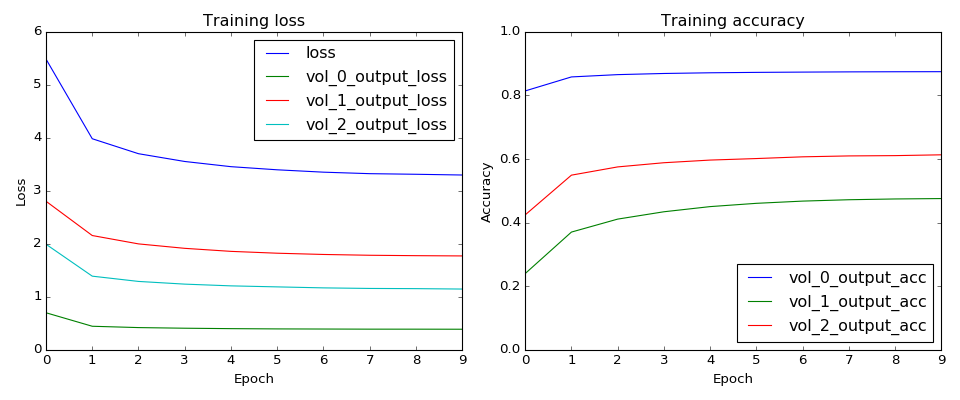

In [20]:
loss_keys = sorted(k for k in history.history.keys() if k.endswith('loss'))
acc_keys = sorted(k for k in history.history.keys() if k.endswith('acc'))
draw_train_history(history, loss_keys=loss_keys, acc_keys=acc_keys)

## Test set evaluation

In [22]:
num_test_files = 1
test_hits_files = hits_files[num_train_files:num_train_files+num_test_files]

In [23]:
test_hits = process_files(test_hits_files)

Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_81.csv
Finished event 0


In [24]:
print('Hits data shape:', test_hits.shape)

Hits data shape: (528029, 7)


In [25]:
%%time
# Select hits
test_selected_hits = select_hits(test_hits)
test_signal_hits = select_signal_hits(test_selected_hits)

# Get the sample keys
test_keys = test_signal_hits[['evtid', 'barcode']].drop_duplicates().values
num_test = test_keys.shape[0]
print('Number of samples available:', num_test)

Number of samples available: 16226
CPU times: user 12.2 s, sys: 68 ms, total: 12.3 s
Wall time: 12.2 s


In [26]:
test_batcher = batch_generator(test_selected_hits, test_signal_hits,
                               test_keys, num_test, bins, ranges)

test_input, test_target = test_batcher.next()
test_pred = model.predict(test_input)
#test_binpred = binmask_prediction(test_pred, test_input)

#test_input, test_target = train_batcher.next()
#test_pred = model.predict(test_input)

### Compute metrics

In [71]:
# Drop seed layers in accuracy calculation
acc_inputs = [test_input[0][:,seed_size:]] + [i for i in test_input[1:]]
acc_targets = [test_target[0][:,seed_size:]] + [t for t in test_target[1:]]
acc_preds = [test_pred[0][:,seed_size:]] + [p for p in test_pred[1:]]
volbinmask_accuracy(acc_inputs, acc_targets, acc_preds)

0.6951453575390467

### Visualization

Model input


<IPython.core.display.Javascript object>


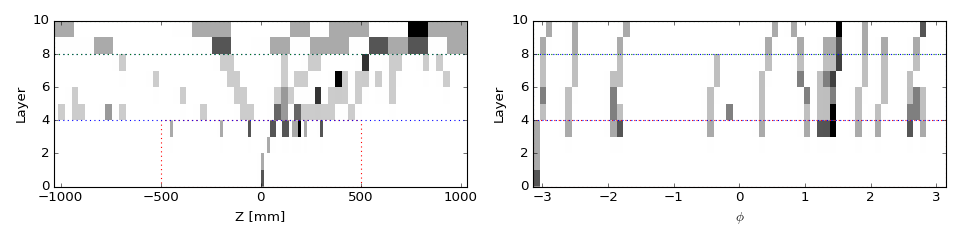

Model target


<IPython.core.display.Javascript object>


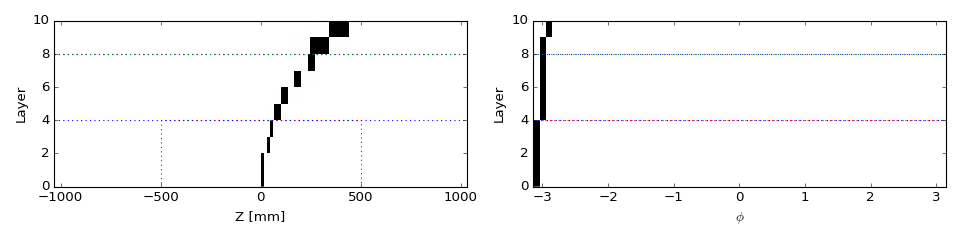

Model prediction


<IPython.core.display.Javascript object>


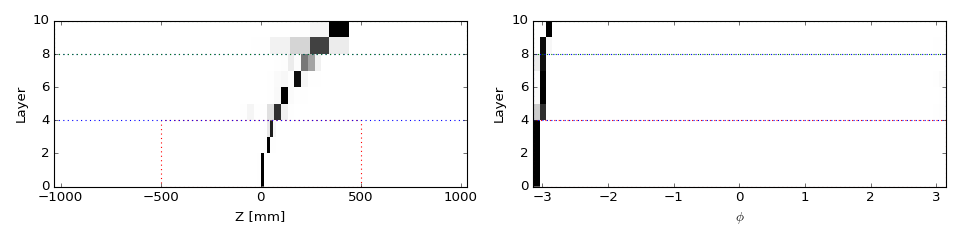

In [68]:
# Visualize a sample
i = 0
vis_input = [t[i] for t in test_input]
vis_target = [t[i] for t in test_target]
vis_pred = [t[i] for t in test_pred]
print('Model input')
draw_vol_projections(vis_input, bins, ranges)
print('Model target')
draw_vol_projections(vis_target, bins, ranges)
print('Model prediction')
draw_vol_projections(vis_pred, bins, ranges)